In [1]:
# !pip install pytorch-metric-learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
import torchvision.transforms as transform
import pytorch_metric_learning as pml

In [2]:

train_ds = torchvision.datasets.LFWPeople(root="./data",split="train",download=True,
                                          transform=torchvision.transforms.ToTensor())
val_ds = torchvision.datasets.LFWPeople(root="./data",split="test",download=True,
                                        transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,original_data,classes_per_batch=10,samples_per_class=2):
        self.targets = np.array(original_data.targets)
        self.uniques = np.unique(self.targets)
        self.original_data = original_data
        self.classes_per_batch = classes_per_batch
        self.samples_per_class = samples_per_class
        ls=[]
        for i in np.unique(self.targets):
            ls.append(len(np.where(self.targets ==i)[0]))

        ls = np.array(ls)
        self.proper_classes = self.uniques[np.where(ls>=samples_per_class)[0]]
        
    def __len__(self):
        return np.sum([bool(np.sum(np.equal(i,self.proper_classes))) for i in self.targets])
    
    def __getitem__(self,idx):
        
        chosen_cls=np.random.choice(self.proper_classes,self.classes_per_batch,replace=False)
        chosen_samples = []
        for cls in chosen_cls:
            i = np.where(self.targets == cls)[0]
            j=np.random.choice(i,self.samples_per_class)
            chosen_samples.append(j)
        chosen_samples=np.concatenate(chosen_samples)
#         paths = [self.original_data.data[i] for i in chosen_samples]
        X = torch.zeros([len(chosen_samples),3,250,250])
        for i,path in enumerate(chosen_samples):
            img = self.original_data[path][0]
            X[i] = img
        return X,torch.tensor(self.targets[chosen_samples])


In [4]:
train_set = dataset(train_ds)
val_set = dataset(val_ds)

In [5]:
model = torchvision.models.resnet18(pretrained=True)

model.fc = nn.Linear(512,128)
model = model.to("cuda:0")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/abbas/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [9]:

# batch_size = 16
# train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True)
# val_loader = DataLoader(val_set,batch_size=batch_size,shuffle=False)
miner_ = pml.miners.BatchEasyHardMiner()
epochs = 10
def smoothen(X,window):
    return np.convolve(X,np.ones(window))/window

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

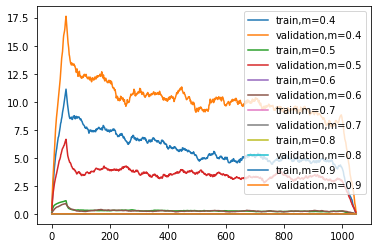

In [11]:
for margin in trange(4,10):
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Linear(512,128)
    model = model.to("cuda:0")
    loss_fn = pml.losses.CircleLoss(m=margin/10).to("cuda:0")
    optimizer = torch.optim.SGD(model.parameters(),1e-4)
    train_loss = []
    val_loss = []

    loop = trange(1000,leave = False)
    for i in loop:
        model.train()
        X,y=train_set[0]
        optimizer.zero_grad()
        X = X.to("cuda:0")
        out = torch.nn.functional.normalize(model(X))
        y = y.to("cuda:0")
        idx = miner_(out,y)
        loss = loss_fn(out,y,idx)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        model.eval()

        with torch.no_grad():
            X,y = val_set[1]
            X = X.to("cuda:0")
            out = torch.nn.functional.normalize(model(X))
            y = y.to("cuda:0")
            loss = loss_fn(out,y)


            val_loss.append(loss.item())
        loop.set_postfix(dict(train = train_loss[-1],val = val_loss[-1]))
    plt.plot(smoothen(train_loss,50),label = f"train,m={margin/10}")
    plt.plot(smoothen(val_loss,50), label=f"validation,m={margin/10}")
plt.legend()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

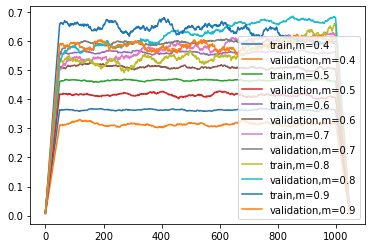

In [12]:
for margin in trange(4,10):
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = nn.Linear(512,128)
    model = model.to("cuda:0")
    loss_fn = pml.losses.TripletMarginLoss(margin=margin/10).to("cuda:0")
    optimizer = torch.optim.SGD(model.parameters(),1e-4)
    train_loss = []
    val_loss = []

    loop = trange(1000,leave = False)
    for i in loop:
        model.train()
        X,y=train_set[0]
        optimizer.zero_grad()
        X = X.to("cuda:0")
        out = torch.nn.functional.normalize(model(X))
        y = y.to("cuda:0")
        idx = miner_(out,y)
        loss = loss_fn(out,y,idx)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        model.eval()

        with torch.no_grad():
            X,y = val_set[1]
            X = X.to("cuda:0")
            out = torch.nn.functional.normalize(model(X))
            y = y.to("cuda:0")
            loss = loss_fn(out,y)


            val_loss.append(loss.item())
        loop.set_postfix(dict(train = train_loss[-1],val = val_loss[-1]))
    plt.plot(smoothen(train_loss,50),label = f"train,m={margin/10}")
    plt.plot(smoothen(val_loss,50), label=f"validation,m={margin/10}")
plt.legend()
plt.show()